<a href="https://colab.research.google.com/github/llA-Wilsonll/Simpsons_Character_Recognition/blob/master/The_Simpsons_Building_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing required packages

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
import re
import itertools
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from sklearn.metrics import classification_report, confusion_matrix

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile 
import os

# Loading the Data Directory
We start off by loading the data (from Google Drive) which has already been prepared (in the The_Simpsons_Organise_Data Notebook) into a directory structure such that we can use the `ImageDataGenerator` method `flow_from_directory`.

In [3]:
# Insert your file ID
# An example : https://drive.google.com/file/d/1iz5JmTB4YcBvO7amj3Sy2_scSeAsN4gd/view?usp=sharing
zip_id = '1Efm6aoutC8kQ36b-sCzewpj1pov4aoMB'

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('/content/simpsons_generator'):
    os.makedirs('/content/simpsons_generator')

# 2. Download Zip
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('simpsons_generator_directory_edit.zip')

# 3. Unzip
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('simpsons_generator_directory_edit.zip', 'r')
zip_ref.extractall('/content/simpsons_generator/')
zip_ref.close()

Uncompressing zip file


## Training Images

In [0]:
base_dir = '/content/simpsons_generator/simpsons_generator_directory_edit/'

In [5]:
characters = os.listdir(base_dir + 'training')

num_images_train = {}
for character in characters:
  num_images = len(os.listdir(base_dir + 'training/' + character))
  num_images_train[character] = num_images
  
# Printing the frequency table
listofTuples = sorted(num_images_train.items(), reverse=True, key=lambda x: x[1])
 
# Iterate over the sorted sequence
print("NUMBER OF TRAINING IMAGES")
for elem in listofTuples :
    print("{0:<26}{1:^2}{2:>13}".format(elem[0],"::", str(elem[1]) + " images."))

NUMBER OF TRAINING IMAGES
homer_simpson             :: 2021 images.
ned_flanders              :: 1308 images.
moe_szyslak               :: 1306 images.
lisa_simpson              :: 1218 images.
bart_simpson              :: 1207 images.
marge_simpson             :: 1161 images.
krusty_the_clown          :: 1085 images.
principal_skinner         :: 1074 images.
charles_montgomery_burns  :: 1073 images.
milhouse_van_houten       ::  996 images.
chief_wiggum              ::  918 images.
abraham_grampa_simpson    ::  852 images.
sideshow_bob              ::  839 images.
apu_nahasapeemapetilon    ::  602 images.


## Validation Images

In [6]:
characters = os.listdir(base_dir + 'validation')

num_images_valid = {}
for character in characters:
  num_images = len(os.listdir(base_dir + 'validation/' + character))
  num_images_valid[character] = num_images
  
# Printing the frequency table
listofTuples = sorted(num_images_valid.items(), reverse=True, key=lambda x: x[1])
 
# Iterate over the sorted sequence
print("NUMBER OF VALIDATION IMAGES")
for elem in listofTuples :
    print("{0:<26}{1:^2}{2:>13}".format(elem[0],"::", str(elem[1]) + " images."))

NUMBER OF VALIDATION IMAGES
homer_simpson             ::  225 images.
ned_flanders              ::  146 images.
moe_szyslak               ::  146 images.
lisa_simpson              ::  136 images.
bart_simpson              ::  135 images.
marge_simpson             ::  130 images.
krusty_the_clown          ::  121 images.
principal_skinner         ::  120 images.
charles_montgomery_burns  ::  120 images.
milhouse_van_houten       ::  115 images.
chief_wiggum              ::  105 images.
sideshow_bob              ::   96 images.
abraham_grampa_simpson    ::   96 images.
apu_nahasapeemapetilon    ::   70 images.


## Test Images

In [7]:
# Getting a list of images in our test directory
images_list = os.listdir(base_dir + 'testing/test_folder')

# Using regex to remove numbers from list of image names
def remove(list): 
    pattern = '[0-9]'
    list = [re.sub(pattern, '', i) for i in list] 
    return list
  
images_list = remove(images_list)

# Removing subscript from file name so only character name remains
images_list = [character.replace("_.jpg","") for character in images_list]

# Creating a freqency table for each character in our test set
num_images_test = {} 
  
for i in images_list: 
  if i in num_images_test: 
      num_images_test[i] += 1
  else: 
      num_images_test[i] = 1

# Printing the frequency table
listofTuples = sorted(num_images_test.items(), reverse=True,
                      key=lambda x: x[1])
 
print("NUMBER OF TESTING IMAGES")
# Iterate over the sorted sequence
for elem in listofTuples :
    print("{0:<26}{1:^2}{2:>13}".format(elem[0],"::", str(elem[1]) + " images."))

NUMBER OF TESTING IMAGES
moe_szyslak               ::   50 images.
krusty_the_clown          ::   50 images.
lisa_simpson              ::   50 images.
bart_simpson              ::   50 images.
chief_wiggum              ::   50 images.
apu_nahasapeemapetilon    ::   50 images.
homer_simpson             ::   50 images.
principal_skinner         ::   50 images.
marge_simpson             ::   50 images.
ned_flanders              ::   49 images.
milhouse_van_houten       ::   49 images.
charles_montgomery_burns  ::   48 images.
abraham_grampa_simpson    ::   48 images.
sideshow_bob              ::   47 images.


# Baseline Model
## Defining the Model
We will start off with a simple model whose accuracy will act as a baseline target for which we will try to improve upon (assuming the baseline isn't already good).

In [20]:
# Getting the number of classes (characters) we are training on
num_characters = len(os.listdir(base_dir + 'training'))
print("We have", num_characters, "characters.")

# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_characters, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc'])

We have 14 characters.


Using the `flow_from_directory` method from `ImageDataGenerator` to point to our training and validation data.

In [8]:
TRAINING_DIR = base_dir + 'training/'
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(64, 64))

VALIDATION_DIR = base_dir + 'validation/'
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='categorical',
                                                              target_size=(64, 64))

Found 15660 images belonging to 14 classes.
Found 1761 images belonging to 14 classes.


## Training the Model

In [24]:
history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/15
157/157 [==============================] - 53s 336ms/step - loss: 1.9426 - acc: 0.3720 - val_loss: 1.4457 - val_acc: 0.5309
Epoch 2/15
157/157 [==============================] - 49s 309ms/step - loss: 1.1946 - acc: 0.6352 - val_loss: 1.0236 - val_acc: 0.6826
Epoch 3/15
157/157 [==============================] - 48s 307ms/step - loss: 0.8551 - acc: 0.7337 - val_loss: 0.8613 - val_acc: 0.7325
Epoch 4/15
157/157 [==============================] - 48s 307ms/step - loss: 0.6324 - acc: 0.8068 - val_loss: 0.7192 - val_acc: 0.7853
Epoch 5/15
157/157 [==============================] - 48s 307ms/step - loss: 0.4562 - acc: 0.8606 - val_loss: 0.6752 - val_acc: 0.7967
Epoch 6/15
157/157 [==============================] - 48s 307ms/step - loss: 0.3177 - acc: 0.9049 - val_loss: 0.6427 - val_acc: 0.8154
Epoch 7/15
157/157 [==============================] - 48s 304ms/step - loss: 0.2050 - acc: 0.9386 - val_loss: 0.6479 - val_acc: 0.8268
Epoch 8/15
157/157 [==============================] - 4

Plotting the Loss and Accuracy:

Text(0.5, 1.0, 'Training and validation loss')

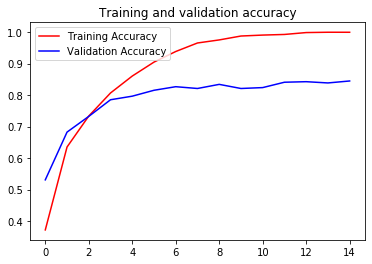

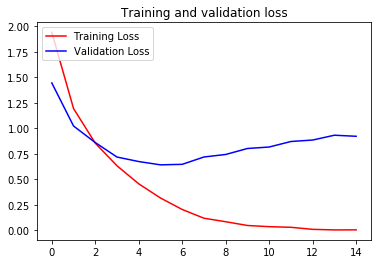

In [37]:
%matplotlib inline

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.legend(loc='upper left')


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

It is clear that our model is overfitting. It is achieving an accuracy of 99.97% on the training set and only 84.5% on the validation set.

## Saving the Model
So that we don't have to retrain the model eveytime we want to run this workbook, I will save the model to a h5 file, and store it in Google Drive.

In [0]:
# Saving the model locally
model.save('/content/simpsons_baseline_model.h5')

Saving this h5 file into Google Drive.

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Saving to GoogleDrive
file1 = drive.CreateFile()
file1.SetContentFile('simpsons_baseline_model.h5')
file1.Upload()

### Loading the Model from Google Drive
After I train the model the first time and save it, in all future sessions I want to use this model I can skip the model defining, training and saving steps and start from here.  

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [10]:
# 2. Download h5 file
h5_id = '1q7dKR7dkusAJlIfa4RRxEzlLjnbIJzZ3'
print ("Downloading h5 file")
myzip = drive.CreateFile({'id': h5_id})
myzip.GetContentFile('simpsons_baseline_model.h5')

In [11]:
model_load = tf.keras.models.load_model('/content/simpsons_baseline_model.h5')

# Show the model architecture
model_load.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
c

## Evaluating the Model

We now want to get a better sense of how our final model is performing on the validation data set.

Below we define a new generator on our validation set because we want to grab all images from our validation set exactly once and so we set the batch_size to 1.

In [12]:
validation_test_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_test_generator = validation_test_datagen.flow_from_directory(
    directory = base_dir + 'validation/',
    target_size=(64, 64),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 1761 images belonging to 14 classes.


Seeing how well our model performs with the validation set as its input.

In [0]:
test = model_load.evaluate_generator(generator=validation_test_generator,
                        steps=len(validation_test_generator))

In [15]:
# print(model.metrics_names)
print("The Validation Loss is:", test[1])

The Validation Loss is: 0.84497446


We want to take the evaluation further and analyse how well the model performed for each of the different character classes.

We run the below code to get a sense of what information on the classess we can get from the `validation_test_generator`.

In [16]:
# See what classes we have
print(validation_test_generator.classes) 

# See how many validation images we have
print(len(validation_test_generator.classes))

# See what class index corresponds to which character
print(validation_test_generator.class_indices) 

[ 0  0  0 ... 13 13 13]
1761
{'abraham_grampa_simpson': 0, 'apu_nahasapeemapetilon': 1, 'bart_simpson': 2, 'charles_montgomery_burns': 3, 'chief_wiggum': 4, 'homer_simpson': 5, 'krusty_the_clown': 6, 'lisa_simpson': 7, 'marge_simpson': 8, 'milhouse_van_houten': 9, 'moe_szyslak': 10, 'ned_flanders': 11, 'principal_skinner': 12, 'sideshow_bob': 13}


In [0]:
target_names = validation_test_generator.class_indices

# Using our model to make predictions on the validation_test_generator
Y_pred = model_load.predict_generator(generator=validation_test_generator, 
                                      steps=len(validation_test_generator))

# Returning the class with the highest prediction chance
y_pred = np.argmax(Y_pred, axis=1)

### Classification Report

In [20]:
print('Classification Report')
print(classification_report(validation_test_generator.classes, y_pred, target_names=target_names))

Classification Report
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.89      0.74      0.81        96
  apu_nahasapeemapetilon       0.86      0.89      0.87        70
            bart_simpson       0.74      0.71      0.73       135
charles_montgomery_burns       0.78      0.73      0.76       120
            chief_wiggum       0.90      0.90      0.90       105
           homer_simpson       0.85      0.83      0.84       225
        krusty_the_clown       0.86      0.90      0.88       121
            lisa_simpson       0.77      0.74      0.75       136
           marge_simpson       0.89      0.93      0.91       130
     milhouse_van_houten       0.88      0.92      0.90       115
             moe_szyslak       0.78      0.88      0.83       146
            ned_flanders       0.89      0.90      0.89       146
       principal_skinner       0.89      0.88      0.88       120
            sideshow_bob       0.90      0.92      0.

### Confusion Matrix

Confusion Matrix


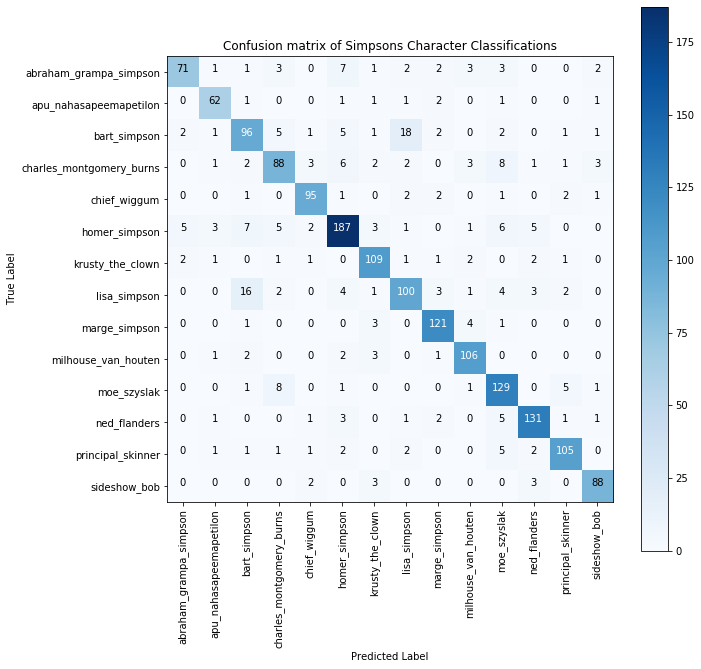

In [72]:
print('Confusion Matrix')
# Creating the confusion matrix as a Numpy array
conf_mtrx = confusion_matrix(validation_test_generator.classes, y_pred)

# Creating a Figure to plot the confusion matirx
fig = plt.figure(figsize = (10,10))
plt.imshow(conf_mtrx, interpolation='none', cmap=plt.cm.Blues)

# Title
plt.title('Confusion matrix of Simpsons Character Classifications')

# Adding a colour bar
plt.colorbar()

# Adding the character names to the X and Y axes
plt.xticks(tick_marks, target_names, rotation=90)
plt.yticks(tick_marks, target_names)

# Adding labels to the X and Y axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Displaying the values for each entry in the confusion matrix
thresh = conf_mtrx.max() / 2.
for i, j in itertools.product(range(conf_mtrx.shape[0]), range(conf_mtrx.shape[1])):
    plt.text(j, i, conf_mtrx[i, j],
             horizontalalignment="center",
             color="white" if conf_mtrx[i, j] > thresh else "black")
    
# Running imshow again because the top and bottom of the plot seem to be
# getting cut off when this isnt run
plt.imshow(conf_mtrx, interpolation='none', cmap=plt.cm.Blues)

From the above confusion matrix, we can see that the model is mixing up its predictions of Bart and Lisa, which does make sense as the both have the same skin and shirt colour, and both have spikey hair. So other characters combinations that the model seems to be getting wrong include Moe - Mr. Burns, Homer - Bart and Homer and Grandpa.

## TO DO
* Find how to stop the model overfitting

In [0]:
"""
Use this code to delete a directory is required
"""
import shutil

shutil.rmtree('/content/simpsons_generator/testing')